In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath,header=0, index_col=0)
    df.index = pd.to_datetime(df.index, format='%m-%d', yearfirst=False)
    #Remove the outlier
    df = df[df["Sales"] < 600]
    #Convert to series
    df = df.squeeze()
    #Resample the data to daily sales
    df = df.resample("D").mean().fillna(method="ffill")
    return df

In [3]:
shampo_sales = wrangle("shampoo.csv")
shampo_sales.shape

/var/folders/xk/dqpblzss3wdd3mcn7lz9ldw00000gn/T/ipykernel_7566/435739095.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample("D").mean().fillna(method="ffill")


(70,)

In [4]:
cutoff = int(len(shampo_sales) * 0.8)
y_train = shampo_sales.iloc[:cutoff]
y_test = shampo_sales[cutoff:]

print(len(shampo_sales))
print(len(y_train))
print(len(y_test))

70
56
14


In [5]:
y_train_mean = y_train.mean()
y_pred_baselin = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baselin)
print("Mean Sales:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Sales: 240.95
Baseline MAE: 69.06


## Build Model with Hyperparameters

In [11]:
# Create range to test different lags
p_params = range(1, 20)

# Create empty list to hold mean absolute error scores
maes = []

# Iterate through all values of p in `p_params`
for p in p_params:
    # Build model
    model = AutoReg(y_train, lags=p).fit()

    # Make predictions on training data, dropping null values caused by lag
    y_pred = model.predict().dropna()

    # Calculate mean absolute error for training data vs predictions
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)

    # Append `mae` to list `maes`
    maes.append(mae)

# Put list `maes` into Series with index `p_params`
mae_series = pd.Series(maes, name="mae", index=p_params)

# Inspect head of Series
mae_series

1     39.555855
2     26.098393
3     24.342048
4     24.708786
5     25.188152
6     25.641439
7     23.873477
8     22.375934
9     22.983072
10    20.977385
11    18.718342
12    19.142283
13    17.725230
14    17.616713
15    17.629491
16    18.265654
17    18.762038
18    19.410726
19    18.897718
Name: mae, dtype: float64

In [12]:
best_model = AutoReg(y_train, lags=14).fit()

## Evaluation

In [13]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

Month
1900-01-15   -18.360821
1900-01-16     5.256400
1900-01-17   -15.448831
1900-01-18    -2.510469
1900-01-19    31.555438
Freq: D, Name: residuals, dtype: float64

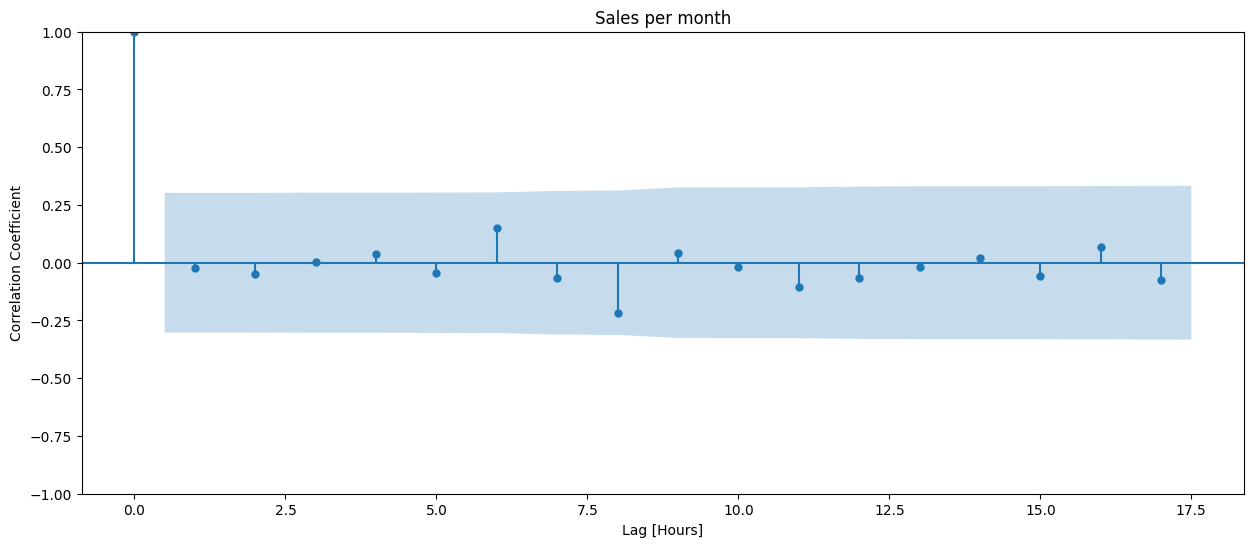

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Sales per month");

In [24]:
y_pred_wfv = pd.Series(dtype=float)
history = y_train.copy()

for i in range(len(y_test)):
    model = AutoReg(history, lags=14).fit()
    next_pred = model.forecast()
    
    # Append using pd.concat
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    
    # Update history by adding the next observed value
    history = pd.concat([history, y_test[next_pred.index]])

y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"

print(y_pred_wfv.head())
_baselin

/var/folders/xk/dqpblzss3wdd3mcn7lz9ldw00000gn/T/ipykernel_7566/2806671809.py:7: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

/Users/mac/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/mac/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/mac/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model wit

timestamp
1900-02-26 00:00:00    344.958890
57                     395.717423
58                     643.296575
59                     621.080575
60                     668.606403
Name: prediction, dtype: float64

/var/folders/xk/dqpblzss3wdd3mcn7lz9ldw00000gn/T/ipykernel_7566/2667312603.py:1: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.



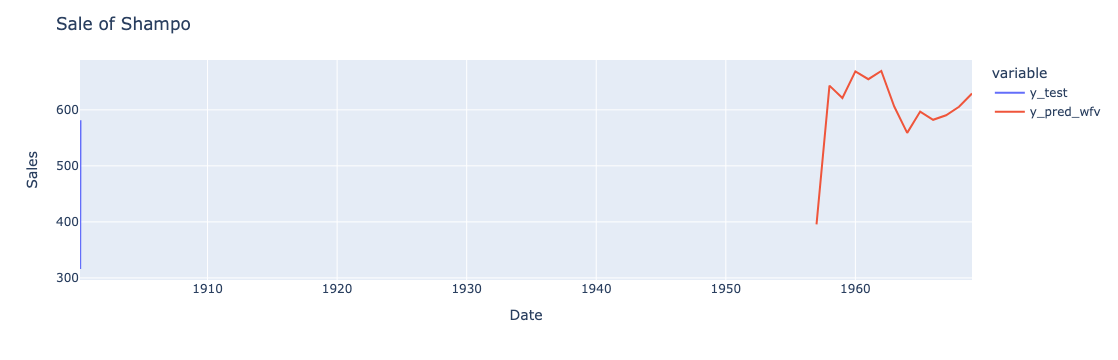

In [25]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred_wfv": y_pred_wfv
    }
)
fig = px.line(df_pred_test, labels={"value": "Shampo"})
fig.update_layout(
    title="Sale of Shampo",
    xaxis_title="Date",
    yaxis_title="Sales",
)

fig.show()